<a href="https://colab.research.google.com/github/cs145442/nlp-projects-with-tf2/blob/master/sentiment_classification_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Handling the dependencies

In [1]:
# install all the dependencies here
! pip install bert-for-tf2

     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30539 sha256=b3b023176595ae509f33d22e00b8e7a7741c2faa6866dcd7f1657d7df764bab8
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=1eb96bd2296fbd0208830176df85026283bb40f94ae7f98bf672f608583b2e96
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=fe69f50b0c8a1a214176168264c1808ff4babab095ff0309e5e71ed6ae85f4d3
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [2]:
# import all the dependencies here
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers

import tensorflow_hub as hub
import pandas as pd
import bert

import math
import random
import spacy

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout

In [51]:
# second version of imports defined here
from keras.layers import Input
from keras.models import Model

## 1. Gathering the data

### 1.1 Getting the dataset

In [4]:
# add and unzip the dataset here
! ls
! wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
! unzip stanfordSentimentTreebank.zip

sample_data
--2020-11-25 05:24:44--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2020-11-25 05:24:44--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  10.3MB/s    in 0.6s    

2020-11-25 05:24:44 (10.3 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
 

In [5]:
! cat stanfordSentimentTreebank/README.txt

Stanford Sentiment Treebank V1.0

This is the dataset of the paper:

Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank
Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng and Christopher Potts
Conference on Empirical Methods in Natural Language Processing (EMNLP 2013)

If you use this dataset in your research, please cite the above paper.

@incollection{SocherEtAl2013:RNTN,
title = {{Parsing With Compositional Vector Grammars}},
author = {Richard Socher and Alex Perelygin and Jean Wu and Jason Chuang and Christopher Manning and Andrew Ng and Christopher Potts},
booktitle = {{EMNLP}},
year = {2013}
}

This file includes:
1. original_rt_snippets.txt contains 10,605 processed snippets from the original pool of Rotten Tomatoes HTML files. Please note that some snippet may contain multiple sentences.

2. dictionary.txt contains all phrases and their IDs, separated by a vertical line |

3. sentiment_labels.txt contains all phrase 

### 1.2 Exploring the dataset

In [6]:
# take a peek at the dataset format
! echo "----- contents of the treebank -------------------"
! ls stanfordSentimentTreebank
! echo "----- first 5 lines of dictionary.txt ------------"
! tail -n 5 stanfordSentimentTreebank/dictionary.txt
! echo "----- first 5 lines of sentiment_labels.txt ------"
! tail -n 5 stanfordSentimentTreebank/sentiment_labels.txt

----- contents of the treebank -------------------
datasetSentences.txt  dictionary.txt		README.txt	      SOStr.txt
datasetSplit.txt      original_rt_snippets.txt	sentiment_labels.txt  STree.txt
----- first 5 lines of dictionary.txt ------------
zoning ordinances to protect your community from the dullest science fiction|220441
zzzzzzzzz|179256
élan|220442
É|220443
É um passatempo descompromissado|220444
----- first 5 lines of sentiment_labels.txt ------
239227|0.36111
239228|0.38889
239229|0.33333
239230|0.88889
239231|0.5


In [7]:
# reading the dataset
dataset_df = pd.read_csv('stanfordSentimentTreebank/dictionary.txt', sep='\n')
dataset_df.head()

,!|0
0,! '|22935
1,! ''|18235
2,! Alas|179257
3,! Brilliant|22936
4,! Brilliant !|40532


In [8]:
# formatting the dataframe for processing
dataset_df['phrase_text'] = dataset_df['!|0'].apply(lambda x: x.split('|')[0])
dataset_df['phrase_ids'] = dataset_df['!|0'].apply(lambda x: x.split('|')[1])
dataset_df = dataset_df.drop('!|0', axis=1)

In [9]:
# take a peek at the dataframe
dataset_df.tail()

,phrase_text,phrase_ids
239226,zoning ordinances to protect your community fr...,220441
239227,zzzzzzzzz,179256
239228,élan,220442
239229,É,220443
239230,É um passatempo descompromissado,220444


In [10]:
# reading the sentiment data
sentiment_df = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='\n')
sentiment_df.head()

,phrase ids|sentiment values
0,0|0.5
1,1|0.5
2,2|0.44444
3,3|0.5
4,4|0.42708


### 1.3 Formatting the dataset

In [11]:
# formatting the sentiment dataframe for processing
sentiment_df['phrase_ids'] = sentiment_df['phrase ids|sentiment values'].apply(lambda x: x.split('|')[0])
sentiment_df['sentiment_values'] = sentiment_df['phrase ids|sentiment values'].apply(lambda x: x.split('|')[1])
sentiment_df = sentiment_df.drop('phrase ids|sentiment values', axis=1)

In [12]:
sentiment_df.head()

,phrase_ids,sentiment_values
0,0,0.5
1,1,0.5
2,2,0.44444
3,3,0.5
4,4,0.42708


In [13]:
# let's merge the phrases and sentiments
dataset_sentiment_df = pd.merge(left=dataset_df, right=sentiment_df, how='inner', on='phrase_ids')
# let's also validate the number of datapoints
print(f"dataset df shape: {dataset_df.shape}")
print(f"sentiment df shape: {sentiment_df.shape}")
print(f"dataset_sentiment df shape: {dataset_sentiment_df.shape}")

dataset df shape: (239231, 2)
sentiment df shape: (239232, 2)
dataset_sentiment df shape: (239231, 3)


*seems good. we missed one datapoint while merging, that's okay for now.*

In [97]:
def recover_sentiment_class(sentiment_value: float):
  """
  recovering classes from sentiment_values
  [very negative, negative, neutral, positive, very positive]
  [0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]
  [1, 2, 3, 4, 5]
  respectively
  :params:
    sentiment_value: floating value of sentiment
  """
  if sentiment_value <= 0.2:
    return 0
  elif sentiment_value <= 0.4:
    return 1
  elif sentiment_value <= 0.6:
    return 2
  elif sentiment_value <= 0.8:
    return 3
  else:
    return 4

In [98]:
dataset_sentiment_df['sentiment_class'] = dataset_sentiment_df['sentiment_values'].apply(
    lambda x: recover_sentiment_class(float(x)))

In [99]:
dataset_sentiment_df.tail()

,phrase_text,phrase_ids,sentiment_values,sentiment_class
239226,zoning ordinances to protect your community fr...,220441,0.13889,0
239227,zzzzzzzzz,179256,0.19444,0
239228,élan,220442,0.51389,2
239229,É,220443,0.5,2
239230,É um passatempo descompromissado,220444,0.5,2


## 2. Generate Input Features

### 2.1 Generating the word vectors With Keras Tokenizer

In [38]:
phrase_max_length = len(max(list(dataset_df['phrase_text']), key=len))
print(f"phrase_max_length: {phrase_max_length}")

phrase_max_length: 267


*we've a phrase with max length of 267 characters*

In [44]:
num_words = 3000
keras_tokenizer = Tokenizer(num_words=num_words, split=' ')
keras_tokenizer.fit_on_texts(dataset_sentiment_df['phrase_text'].values)
sequenced_dataset = keras_tokenizer.texts_to_sequences(dataset_sentiment_df['phrase_text'])
sequenced_dataset = pad_sequences(sequenced_dataset, padding='post', maxlen=phrase_max_length)

### 2.2 Generating the POS Tags
*Indicates the part-of-speech tag of the word*

In [18]:
# load the spacy model
spacy_nlp_model = spacy.load("en_core_web_sm")

In [22]:
list_of_phrases = list(dataset_sentiment_df['phrase_text'])

In [24]:
# let's create the spacy token objects of all the sequences
list_of_phrases_spacy_docs = [spacy_nlp_model(phrase) for phrase in list_of_phrases]

In [25]:
def get_pos_tags(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's POS Tags
  """
  # generator of pos tags for the sequence or word
  tags = []
  for token in doc:
    tags.append(token.pos_)
  return tags


dict_of_pos_tags = {}
def get_pos_tag2id(pos_tag: str):
  """
  returns the id for the POS Tag from the universal dict of POS Tags
  """
  id = dict_of_pos_tags.get(pos_tag, None)
  if id is None:
    # i.e, POS Tag is not in the dict
    # Add the new POS Tag to the dict
    new_id = len(dict_of_pos_tags) + 1
    dict_of_pos_tags[pos_tag] = new_id
    return new_id
  else:
    return id


def get_pos_tag_ids(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's POS Tags ID's
  """
  tag_ids = []
  for token in doc:
    tag_ids.append(get_pos_tag2id(token.pos_))
  return tag_ids

In [26]:
list_of_phrases_pos_tags = [get_pos_tags(phrase) for phrase in list_of_phrases_spacy_docs]
list_of_phrases_pos_tag_ids = [get_pos_tag_ids(phrase) for phrase in list_of_phrases_spacy_docs]

### 2.3 Generate the word shape
*Indicates whether a word start with a captial letter?*

In [27]:
def get_word_shape(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's shape
  """
  shapes = []
  for token in doc:
    shapes.append(token.shape_)
  return shapes

def get_init_word_case_match(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's initial case match indicator
  indicators: 1 if the token begins with an UPPERCASE letter
  indicators: 2 if the token begins with an lowercase letter
  """
  init_word_case_match = []
  for token in doc:
    init_word_case_match.append(1 if token.text.istitle() else 2)
  return init_word_case_match

In [28]:
# list_of_phrases_word_shape
list_of_phrases_word_shape = [get_word_shape(phrase) for phrase in list_of_phrases_spacy_docs]
list_of_phrases_init_word_case_match = [get_init_word_case_match(phrase) for phrase in list_of_phrases_spacy_docs]

### 2.4 Generate the lemmatized word sequence
*Indicates whether a word end with an “ing” or with “ly” or neither?*

In [29]:
def get_word_lemma(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's lemma
  """
  lemmas = []
  for token in doc:
    lemmas.append(token.lemma_)
  return lemmas

def get_word_lemma_match(doc: spacy.tokens.doc.Doc):
  """
  returns a list of token's lemma match indicator
  indicators: 1 if there's a match of token with it's lemma
  indicators: 2 if there's not a match of token with it's lemma
  """
  lemma_match = []
  for token in doc:
    if token.text == token.lemma_:
      lemma_match.append(1)
    else:
      lemma_match.append(2)
  return lemma_match

In [30]:
list_of_phrases_lemma = [get_word_lemma(phrase) for phrase in list_of_phrases_spacy_docs]
list_of_phrases_lemma_match = [get_word_lemma_match(phrase) for phrase in list_of_phrases_spacy_docs]

## 3. Sentiment Analysis 
#### without multiple input features

### 3.1 Sentiment Analysis with Keras Tokenizer using LSTM

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    sequenced_dataset,
    dataset_sentiment_df['sentiment_class'],
    test_size = 0.40,
    random_state = 42
    )

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [106]:
# define hyperparams here
vocab_size = num_words + 1
embed_dim = 128
lstm_neurons = 196
output_classes_count = 5

In [107]:
input_1 = Input(shape=(phrase_max_length,))
embedding_layer = Embedding(vocab_size, embed_dim)(input_1)
lstm_layer_1 = LSTM(lstm_neurons)(embedding_layer)
dense_layer_1 = Dense(output_classes_count, activation='softmax')(lstm_layer_1)
model = Model(inputs=input_1, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
print(model.summary())

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 267)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 267, 128)          384128    
_________________________________________________________________
lstm_9 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 985       
Total params: 639,913
Trainable params: 639,913
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.3)

Epoch 1/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3052 - accuracy: 0.4979 - val_loss: 1.2963 - val_accuracy: 0.5043
Epoch 2/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3053 - accuracy: 0.4979 - val_loss: 1.2971 - val_accuracy: 0.5043
Epoch 3/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3055 - accuracy: 0.4979 - val_loss: 1.2976 - val_accuracy: 0.5043
Epoch 4/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3055 - accuracy: 0.4979 - val_loss: 1.2965 - val_accuracy: 0.5043
Epoch 5/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3054 - accuracy: 0.4979 - val_loss: 1.2965 - val_accuracy: 0.5043
Epoch 6/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3054 - accuracy: 0.4979 - val_loss: 1.2963 - val_accuracy: 0.5043
Epoch 7/10
785/785 [==============================] - 38s 49ms/step - loss: 1.3054 - accuracy: 0.4979 - val_loss: 1.2965 - val_accuracy:

In [111]:
model.evaluate(X_test, y_test)

2991/2991 [==============================] - 22s 7ms/step - loss: 1.3021 - accuracy: 0.4999


[1.3020628690719604, 0.49994251132011414]

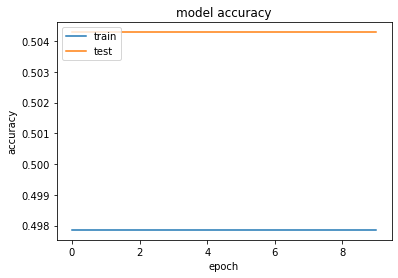

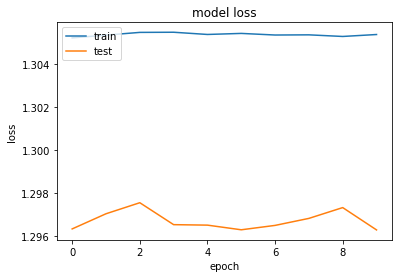

In [114]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### integrating multiple input features